In [204]:
## Load Required Library
!pip install pytesseract


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [205]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR/tesseract.exe'  # Adjust if different


In [206]:
# Define dataset paths
data_dir = "../dataset/"  # Update as needed
folders = ["Training", "Testing", "Validation"]
image_size = (250, 250)

In [207]:
def load_data(folder):
    csv_path = os.path.join(data_dir, folder, "labels.csv")
    image_folder = os.path.join(data_dir, folder, "images")

    # Load CSV
    df = pd.read_csv(csv_path)

    images = []
    labels = []

    for index, row in df.iterrows():
        image_filename = row["IMAGE"]
        image_path = os.path.join(image_folder, image_filename)

        if os.path.exists(image_path):
            # Load image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # ✅ Resize with interpolation to maintain quality
            image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)

            # ✅ Convert to Grayscale for OCR
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

            # ✅ Enhance Contrast using CLAHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced = clahe.apply(gray)

            # ✅ Apply Adaptive Thresholding for better text edges
            thresh = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                           cv2.THRESH_BINARY, 11, 2)

            images.append(thresh)  # Use thresholded image for OCR
            labels.append(row["MEDICINE_NAME"])

        else:
            print(f"⚠️ Warning: Image {image_filename} not found in {image_folder}!")

    return np.array(images), np.array(labels)


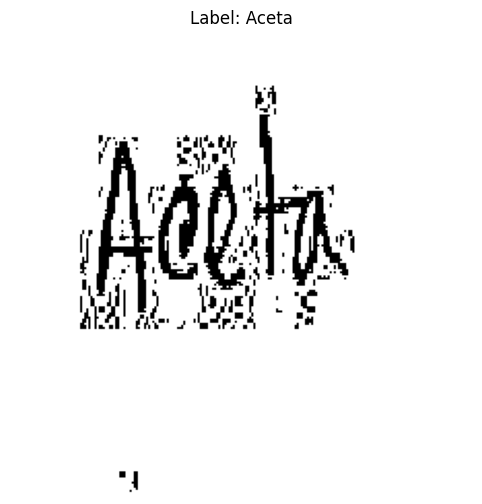

In [208]:
# Load Data
train_images, train_labels = load_data("Training")

# Display Sample Preprocessed Image
sample_index = 1  # Change this for different images

plt.figure(figsize=(8, 6))
plt.imshow(train_images[sample_index], cmap='gray')  # Show thresholded image
plt.title(f"Label: {train_labels[sample_index]}")
plt.axis("off")
plt.show()


In [209]:


# Sample Image
sample_image = train_images[1]

# Tesseract OCR
extracted_text = pytesseract.image_to_string(sample_image, config='--oem 3 --psm 6')
print(f"Extracted Text: {extracted_text}")


Extracted Text: 4
4



In [210]:
def segment_images(images):
    extracted_texts = []
    custom_config = r'--oem 3 --psm 6'

    for idx, img in enumerate(images):
        # Step 1: Convert to Grayscale if not already
        if len(img.shape) == 3 and img.shape[2] == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            gray = img

        # Step 2: Resize for better OCR
        resized = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

        # Step 3: Apply Gaussian Blur to reduce noise
        blurred = cv2.GaussianBlur(resized, (5, 5), 0)

        # Step 4: Apply Thresholding (Binarization)
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Step 5: Tesseract OCR
        text = pytesseract.image_to_string(thresh, config=custom_config)
        extracted_texts.append(text.strip())

        # Show image and extracted text for debugging
        plt.figure(figsize=(4, 4))
        plt.imshow(thresh, cmap='gray')
        plt.title(f"Extracted Text: {text}")
        plt.axis("off")
        plt.show()

    return extracted_texts


In [211]:
# # Apply segmentation
# # Load your data
train_images, train_labels = load_data("Training")
test_images, test_labels = load_data("Testing")
val_images, val_labels = load_data("Validation")

# # Apply segmentation
# train_texts = segment_images(train_images)
# test_texts = segment_images(test_images)
# val_texts = segment_images(val_images)


In [212]:
# Select sample image
sample_index = 83  

# Get extracted text
full_text, char_list = train_texts[sample_index]

# Plot the results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(train_images[sample_index])
plt.title(f"Original Image - Label: {train_labels[sample_index]}")
plt.axis("off")

# Preprocessed Image with Extracted Text
plt.subplot(1, 2, 2)
plt.imshow(thresh, cmap='gray')
plt.title(f"Full Label: {full_text}\nCharacters: {' | '.join(char_list)}")
plt.axis("off")

plt.show()


NameError: name 'train_texts' is not defined

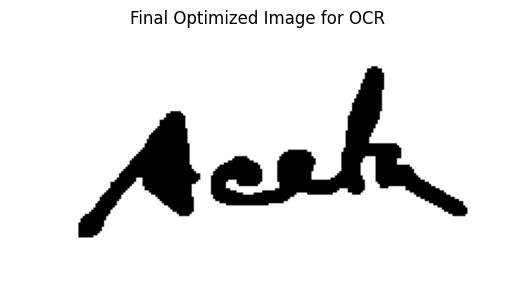

Final Extracted Text: poh


In [219]:


def improved_segmentation(image_path):
# 1️⃣ Read Image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2️⃣ Resize for Clarity
    scale_percent = 100  # 3x enlargement
    width = int(gray.shape[1] * scale_percent / 100)
    height = int(gray.shape[0] * scale_percent / 100)
    resized = cv2.resize(gray, (width, height), interpolation=cv2.INTER_CUBIC)

    # 3️⃣ Apply Gaussian & Median Blurs
    blurred = cv2.GaussianBlur(resized, (5, 5), 0)
    median_blurred = cv2.medianBlur(blurred, 5)

    # 4️⃣ Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(median_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 4)

    # 5️⃣ Morphological Operations (Closing gaps & noise removal)
    kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 6️⃣ Dilate to Strengthen Lines
    dilated = cv2.dilate(morph, kernel, iterations=1)

    # 7️⃣ Contour Filtering (Eliminate small noise)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(dilated)
    for cnt in contours:
        if cv2.contourArea(cnt) > 150:  # Increase area filter
            cv2.drawContours(mask, [cnt], -1, 255, -1)

    # 8️⃣ Invert for Tesseract
    final_img = cv2.bitwise_not(mask)

    # 9️⃣ Tesseract Config
    custom_config = r'--oem 3 --psm 13 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

    # OCR
    text = pytesseract.image_to_string(final_img, config=custom_config)

    # 📊 Show Processed Image
    plt.imshow(final_img, cmap='gray')
    plt.title("Final Optimized Image for OCR")
    plt.axis('off')
    plt.show()

    return text.strip()
    
# Run on uploaded image
image_path = r'D:\jupyter\FYP-OCR\medical_prescription_ocr\dataset\Testing\images\2.png'

extracted_text = improved_segmentation(image_path)
print("Final Extracted Text:", extracted_text)


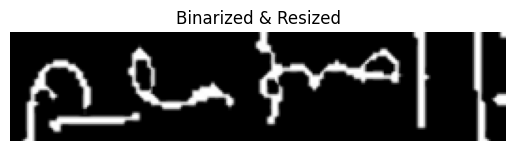

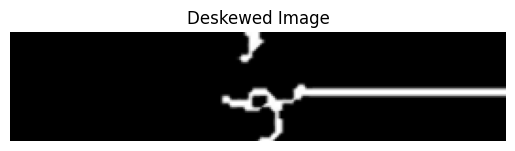

📄 Final Extracted Text:
 -
a


In [228]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Adaptive Thresholding (Inverted)
    binarized = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV, 11, 2)

    # Resize for better OCR
    resized_image = cv2.resize(binarized, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Apply erosion to refine characters
    kernel = np.ones((3, 3), np.uint8)
    morphed_image = cv2.erode(resized_image, kernel, iterations=1)

    return morphed_image

def deskew_image(image):
    # Find angle to deskew
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Rotate the image
    (h, w) = image.shape
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated_image

def extract_text(image):
    # Configure Tesseract for best accuracy
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(image, config=custom_config)
    return text.strip()

def visualize_image(image, title='Processed Image'):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# 🚀 Example Usage
image_path = r'D:\jupyter\FYP-OCR\medical_prescription_ocr\dataset\Testing\images\29.png'

# Preprocessing
preprocessed_image = preprocess_image(image_path)
visualize_image(preprocessed_image, "Binarized & Resized")

# Deskewing
deskewed_image = deskew_image(preprocessed_image)
visualize_image(deskewed_image, "Deskewed Image")

# OCR Extraction
extracted_text = extract_text(deskewed_image)
print("📄 Final Extracted Text:\n", extracted_text)
